In [1]:
# 2017년 논문
# 생성자가 수렴하는 것과  샘플의 품질을 연관짖는 의미 있는 손실 측정방법
# 최적화 과정의 안정성 향상

In [2]:
# 와서스테인 손실

이진크로스 엔트로피 손실 : GAN에서 판별자와 생성자를 훈련하는데 사용

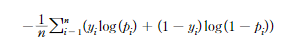

In [ ]:
'''
GAN 판별자 D를 훈련.
GAN의 판별자의 손실함수 최소화
'''

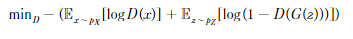

GAN 생성자의 손실 최소화

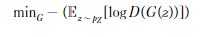

In [ ]:
# 와서스테인 손실은 1과 0대신에 yi=1, yi = -1을 사용
# 판별자의 마지막 층에서 시그모이드 활성화 함수를 제거 예측 pi가 [0,1]범위에 국한되지 않고 [-무한대, 무한대] 범위의 어떤 숫자도
# 될수 있도록 만든다
# WGAN의 판별자는 확률대신 점수를 반환
# 와서스테인 손실함수

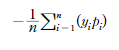

In [4]:
# WGAN의 D를 훈련하기 위해서는 진짜이미지에 대한 예측와 타깃을 비교하고 생성된 이미지에 대한 예측와 타깃을 비교해서
# 손실을 계산 , 진짜이미지와 생성된 이미지에 대한 사이의 차이를 최대화

In [ ]:
# 립시츠 제약 : Lipschitz Constraint
# GAN에서 신경망의 안정성과 수렴성 향상을위해 사용
# GAN의 손실함수에 립시츠 제약을 추가해서 생성기 및 판별기의 거리를 측정하고 두 모델상의 거리를 유지하려는 아이디어


In [5]:
# 데이터 CelebA 얼굴데이터셋
# https://drive.google.com/file/d/18yxnIT0fPQflivmKISyUB85mTTYcJy3J/view?usp=sharing

In [ ]:
!unzip '/content/drive/MyDrive/celeba_face/img_align_celeba.zip'

In [7]:
# 파라메터
IMAGE_SIZE = 64
CHANNELS = 3
BATCH_SIZE = 512
NUM_FEATURES = 64
Z_DIM = 128
LEARNING_RATE = 0.0002
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.999
EPOCHS = 200
CRITIC_STEPS = 3
GP_WEIGHT = 10.0
LOAD_MODEL = False
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.9

In [15]:
# 라이브러리
import numpy as np
import tensorflow as tf
from tensorflow.keras import(
    layers,models,callbacks,utils,metrics,optimizers
)


In [9]:
# utils.py 파일 필요
from utils import display, sample_batch

In [12]:
# 데이터 로드
from glob import glob
imglists = glob('/content/img_align_celeba/*')
imglists[:5]

['/content/img_align_celeba/130924.jpg',
 '/content/img_align_celeba/040219.jpg',
 '/content/img_align_celeba/177662.jpg',
 '/content/img_align_celeba/026790.jpg',
 '/content/img_align_celeba/014259.jpg']

In [13]:
train_data = utils.image_dataset_from_directory(
   '/content/img_align_celeba',
   labels=None,
   color_mode='rgb',
   image_size = (IMAGE_SIZE,IMAGE_SIZE),
   batch_size = BATCH_SIZE,
   shuffle=True,
   seed=42
)

Found 202599 files belonging to 1 classes.


In [16]:
# 데이터 전처리
train = train_data.map( lambda x: (tf.cast(x,'float32')-127.5) / 127.5   )

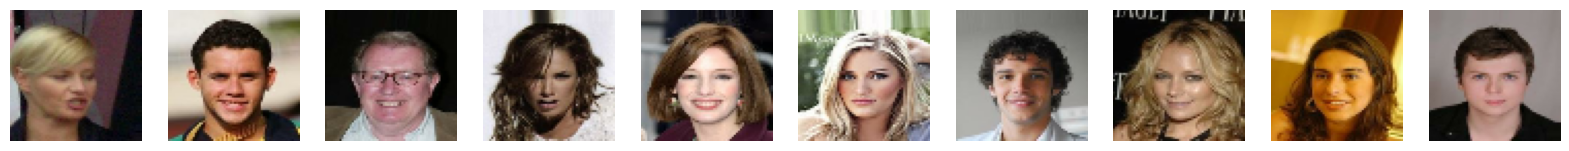

In [18]:
train_sample = sample_batch(train)
display(train_sample)

WGAN-GP 구축

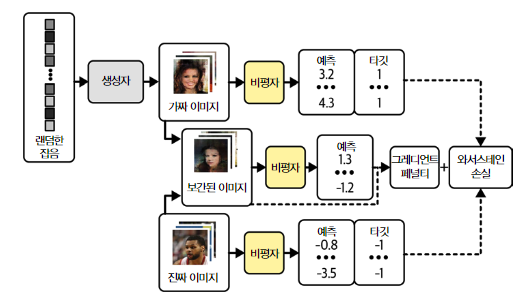

In [19]:
# 판별자... 비평자
critic_input = layers.Input(shape=(IMAGE_SIZE,IMAGE_SIZE,CHANNELS))
x = layers.Conv2D(64,kernel_size=4, strides=2,padding='same')(critic_input)
x = layers.LeakyReLU(0.2)(x)

x = layers.Conv2D(128,kernel_size=4, strides=2,padding='same')(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)

x = layers.Conv2D(256,kernel_size=4, strides=2,padding='same')(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)

x = layers.Conv2D(512,kernel_size=4, strides=2,padding='same')(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)

x = layers.Conv2D(1,kernel_size=4, strides=1,padding='valid')(x)
critic_output = layers.Flatten()(x)
critc = models.Model(critic_input,critic_output)
critc.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 64)        3136      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 dropout (Dropout)           (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 256)         524544

In [23]:
generator_input = layers.Input(shape = (Z_DIM,))
x = layers.Reshape( (1,1,Z_DIM))(generator_input)
x = layers.Conv2DTranspose(512,kernel_size=4, strides=1,padding='valid',use_bias=False)(x)
x = layers.BatchNormalization(momentum = 0.9)(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Conv2DTranspose(256,kernel_size=4, strides=2,padding='same',use_bias=False)(x)
x = layers.BatchNormalization(momentum = 0.9)(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Conv2DTranspose(128,kernel_size=4, strides=2,padding='same',use_bias=False)(x)
x = layers.BatchNormalization(momentum = 0.9)(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Conv2DTranspose(64,kernel_size=4, strides=2,padding='same',use_bias=False)(x)
x = layers.BatchNormalization(momentum = 0.9)(x)
x = layers.LeakyReLU(0.2)(x)

generator_output = layers.Conv2DTranspose(CHANNELS,kernel_size=4, strides=2,padding='same',activation='tanh')(x)
generator = models.Model(generator_input,generator_output)
generator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128)]             0         
                                                                 
 reshape_2 (Reshape)         (None, 1, 1, 128)         0         
                                                                 
 conv2d_transpose_5 (Conv2D  (None, 4, 4, 512)         1048576   
 Transpose)                                                      
                                                                 
 batch_normalization_4 (Bat  (None, 4, 4, 512)         2048      
 chNormalization)                                                
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 4, 4, 512)         0         
                                                                 
 conv2d_transpose_6 (Conv2D  (None, 8, 8, 256)         2097

In [24]:
class WGANGP(models.Model):
  def __init__(self, critic, generator, latent_dim, critic_steps, gp_weight):
    super(WGANGP, self).__init__()
    self.critic = critic
    self.generator = generator
    self.latent_dim = latent_dim
    self.critic_steps = critic_steps
    self.gp_weight = gp_weight

  def compile(self, c_optimizer, g_optimizer):
      super(WGANGP, self).compile()
      self.c_optimizer = c_optimizer
      self.g_optimizer = g_optimizer
      self.c_wass_loss_metric = metrics.Mean(name="c_wass_loss")
      self.c_gp_metric = metrics.Mean(name="c_gp")
      self.c_loss_metric = metrics.Mean(name="c_loss")
      self.g_loss_metric = metrics.Mean(name="g_loss")

  @property
  def metrics(self):
      return [
          self.c_loss_metric,
          self.c_wass_loss_metric,
          self.c_gp_metric,
          self.g_loss_metric,
      ]
  # 그레이디언트 패널티 손실함수
  def gadient_panelty(self, batch_size,real_images,fake_images):
    # 배치에 있는 이미지마다 0과 1사이의 랜덤한 숫자를 생성해서 벡터 alpha저장
    alpha = tf.random.normal([batch_size,1,1,1],0.0,1.0)
    diff = fake_images - real_images
    interpolated = real_images + alpha*diff # 보간 이미지를 계산

    with tf.GradientTape() as gp_tapes:
      gp_tape.watch(interpolated)
      pred = self.critic(interpolated,training=True) # 비평가한테 보간된 이미지의 점수를 요청

    gp_tapes.gradient(pred, [interpolated])[0] # 보간된 이미지에 대해서 예측에 대한 기울기 계산
    norm = tf.sqrt(tf.reduce_sum(tf.square(grads),axis=[1,2,3])) # 벡터의 L2노름을 계산
    # L2노름 : 벡터나 행렬의 크기, 길이를 측정 유클리드 노름 (||x||2)
    # 각 요소의 제곱을 더하고 그 합에 제곱근
    gp = tf.reduce_mean((norm-1.0)**2) # L2노름과 1사이의 평균 제곱 거리를 반환
    return gp

  def train_step(self, real_images):
          batch_size = tf.shape(real_images)[0]

          for i in range(self.critic_steps):
              random_latent_vectors = tf.random.normal(
                  shape=(batch_size, self.latent_dim)
              )

              with tf.GradientTape() as tape:
                  fake_images = self.generator(
                      random_latent_vectors, training=True
                  )
                  fake_predictions = self.critic(fake_images, training=True)
                  real_predictions = self.critic(real_images, training=True)

                  c_wass_loss = tf.reduce_mean(fake_predictions) - tf.reduce_mean(
                      real_predictions
                  )
                  c_gp = self.gradient_penalty(
                      batch_size, real_images, fake_images
                  )
                  c_loss = c_wass_loss + c_gp * self.gp_weight

              c_gradient = tape.gradient(c_loss, self.critic.trainable_variables)
              self.c_optimizer.apply_gradients(
                  zip(c_gradient, self.critic.trainable_variables)
              )

          random_latent_vectors = tf.random.normal(
              shape=(batch_size, self.latent_dim)
          )
          with tf.GradientTape() as tape:
              fake_images = self.generator(random_latent_vectors, training=True)
              fake_predictions = self.critic(fake_images, training=True)
              g_loss = -tf.reduce_mean(fake_predictions)

          gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
          self.g_optimizer.apply_gradients(
              zip(gen_gradient, self.generator.trainable_variables)
          )

          self.c_loss_metric.update_state(c_loss)
          self.c_wass_loss_metric.update_state(c_wass_loss)
          self.c_gp_metric.update_state(c_gp)
          self.g_loss_metric.update_state(g_loss)

          return {m.name: m.result() for m in self.metrics}


In [26]:
#모델
wgangp = WGANGP(
    critic = critc,
    generator = generator,
    latent_dim = Z_DIM,
    critic_steps = CRITIC_STEPS,
    gp_weight = GP_WEIGHT
)